<a href="https://colab.research.google.com/github/link1697/crack_segmentation/blob/main/%E8%B4%A5%E5%8C%97_pytorch_2stage_resize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from keras import metrics
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
import cv2
import PIL
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tqdm import tqdm
from keras import backend as K
import torch.nn.functional as F
import copy

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
import os
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [6]:
def ensure_uint8(image):
    if image.dtype != np.uint8:
        image = (image * 255).clip(0, 255).astype(np.uint8)
    return image

def apply_gaussian_blur(image, kernel_size=(5, 5)):
    # Assuming the input image is a float between 0 and 1
    image = ensure_uint8(image)  # Convert to uint8
    blurred = cv2.GaussianBlur(image, kernel_size, 0)
    return blurred / 255.0  # Re-normalize to float between 0 and 1 if necessary

def apply_sobel_filter(image, ksize=3):
    # Convert to grayscale
    image = ensure_uint8(image)  # Convert to uint8
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    sobel = cv2.addWeighted(np.absolute(sobelx), 0.5, np.absolute(sobely), 0.5, 0)
    sobel = np.clip(sobel, 0, 255).astype(np.uint8)  # Ensure the result is uint8
    return cv2.cvtColor(sobel, cv2.COLOR_GRAY2BGR) / 255.0  # Convert back to BGR and normalize

def apply_gaussian_noise(image, noise_level=5):
    # Assuming the input image is a float between 0 and 1
    image = ensure_uint8(image)  # Convert to uint8
    gauss_noise = np.random.normal(0, noise_level, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, gauss_noise)
    return noisy_image / 255.0  # Re-normalize to float between 0 and 1 if necessary

def color_distort_smooth(image, hue_shift=87, saturation_scale=1.3, value_scale=1.7):
    # Assuming the input image is a float between 0 and 1
    image = ensure_uint8(image)  # Convert to uint8
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    h = (h + hue_shift) % 180
    s = np.clip(s * saturation_scale, 0, 255).astype(np.uint8)
    v = np.clip(v * value_scale, 0, 255).astype(np.uint8)
    final_hsv = cv2.merge((h, s, v))
    color_distorted_image = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return color_distorted_image / 255.0  # Re-normalize if necessary

augmentations = [apply_gaussian_blur, apply_sobel_filter, apply_gaussian_noise, color_distort_smooth]

U-net + MLP

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# U-Net Encoder Blocks
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

# U-Net Encoder Class
class UNetEncoder(nn.Module):
    def __init__(self, in_channels=3, features=32):
        super(UNetEncoder, self).__init__()
        self.enc1 = conv_block(in_channels, features)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.enc2 = conv_block(features, features * 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.enc3 = conv_block(features * 2, features * 4)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.enc4 = conv_block(features * 4, features * 8)
        self.pool4 = nn.MaxPool2d(2, 2)

        # Bottleneck layer
        self.bottleneck = nn.Conv2d(features * 8, features * 16, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.enc1(x)
        x = self.pool1(x)
        x = self.enc2(x)
        x = self.pool2(x)
        x = self.enc3(x)
        x = self.pool3(x)
        x = self.enc4(x)
        x = self.pool4(x)
        x = self.bottleneck(x)

        # Flatten output
        x = x.view(x.size(0), -1)
        return x

# Projection Head Class
class ProjectionHead(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=64):
        super(ProjectionHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Integrate U-Net Encoder and Projection Head
dummy_input = torch.randn(1, 3, 256, 256).to(device)
encoder = UNetEncoder(in_channels=3, features=32).to(device)
encoder_output = encoder(dummy_input)

# Flattened encoder output size
flattened_output = encoder_output.shape[1]

# Create the projection head with the correct input dimension
projection_head = ProjectionHead(input_dim=flattened_output).to(device)

# Test the forward pass with a dummy input
projected_output = projection_head(encoder_output)
print("Projected Output Shape:", projected_output.shape)


Using device: cpu
Projected Output Shape: torch.Size([1, 64])


train encoder+MLP

Fine-tuning dataset

In [8]:
# Define a Dataset Class for Crack Images and Masks
class CrackSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir

        # List all image files in the directory (assuming each has a corresponding mask)
        self.image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Get the image file name and corresponding mask file path
        image_file = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_file)
        mask_path = os.path.join(self.mask_dir, image_file)  # Assuming masks have the same name

        # Load the image and mask
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask as grayscale

        # Normalize both to the range [0, 1] without resizing
        image = image / 255.0  # Normalize image
        mask = mask / 255.0  # Normalize mask

        # Convert to PyTorch tensors and change shape to [C, H, W]
        image_tensor = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32)
        mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Add a channel dimension

        return image_tensor, mask_tensor


# Ensure we use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example Usage
# Replace these paths with the appropriate directories containing your crack images and masks
image_dir = './archive/crack_segmentation_dataset/test/images/'
mask_dir = './archive/crack_segmentation_dataset/test/masks/'
dataset = CrackSegmentationDataset(image_dir, mask_dir)

# Check the total size of the dataset
total_size = len(dataset)
train_size = 300
test_size = 200

# Verify that the total matches your desired split
if train_size + test_size != total_size:
    print(f"Warning: Adjusting train/test split to match dataset length ({total_size})")
    train_size = int(0.6 * total_size)  # Example: 60% for training
    test_size = total_size - train_size

# Split the dataset into training and testing sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for training and testing
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Move batches to the appropriate device (GPU/CPU) for training set
for image_batch, mask_batch in train_loader:
    image_batch = image_batch.to(device)
    mask_batch = mask_batch.to(device)
    print("Training Image Batch Shape:", image_batch.shape)
    print("Training Mask Batch Shape:", mask_batch.shape)
    break

# Move batches to the appropriate device (GPU/CPU) for testing set
for image_batch, mask_batch in test_loader:
    image_batch = image_batch.to(device)
    mask_batch = mask_batch.to(device)
    print("Testing Image Batch Shape:", image_batch.shape)
    print("Testing Mask Batch Shape:", mask_batch.shape)
    break


Training Image Batch Shape: torch.Size([16, 3, 448, 448])
Training Mask Batch Shape: torch.Size([16, 1, 448, 448])
Testing Image Batch Shape: torch.Size([16, 3, 448, 448])
Testing Mask Batch Shape: torch.Size([16, 1, 448, 448])


fine-tuning

用前面unet的encoder

In [9]:

# Residual Block with Debugging
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, num_filters):
        super(ResidualBlock, self).__init__()
        self.projection = None
        if in_channels != num_filters:
            self.projection = nn.Conv2d(in_channels, num_filters, kernel_size=1, stride=1)

        self.conv1 = nn.Conv2d(in_channels, num_filters, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_filters)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_filters)

    def forward(self, x):
        #print(f"Input shape to ResidualBlock: {x.shape}")
        shortcut = x
        if self.projection:
            shortcut = self.projection(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += shortcut
        return self.relu(out)

# Attention Gate
class AttentionGate(nn.Module):
    def __init__(self, skip_channels, gate_channels, out_channels):
        super(AttentionGate, self).__init__()
        # Match the number of channels correctly
        self.conv_gate = nn.Conv2d(gate_channels, out_channels, kernel_size=1)
        self.bn_gate = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv_skip = nn.Conv2d(skip_channels, out_channels, kernel_size=1)
        self.bn_skip = nn.BatchNorm2d(out_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, skip, gate):
        skip_resized = F.interpolate(skip, size=gate.shape[2:], mode='bilinear', align_corners=False)

        # Adjust the gate and skip to have the same dimensions
        gate_resized = self.conv_gate(gate)
        gate_resized = self.bn_gate(gate_resized)
        gate_resized = self.relu(gate_resized)

        skip_resized = self.conv_skip(skip)
        skip_resized = self.bn_skip(skip_resized)

        # Combine the skip and gate tensors
        attention = self.sigmoid(gate_resized + skip_resized)

        # Multiply by the skip tensor
        return skip * attention


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        # Adjust attention gate to receive the correct number of input channels
        self.attention_gate = AttentionGate(skip_channels, out_channels, out_channels)
        # Upsample input channels to expected size
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        # Ensure that the residual block receives the correct input channels
        self.residual_block = ResidualBlock(out_channels + skip_channels, out_channels)

    def forward(self, x, skip):
        #print(f"Shape of x before upconv: {x.shape}")
        x = self.upconv(x)
        #print(f"Shape of x after upconv: {x.shape}")

        # Apply the attention gate to align the skip connection channels
        skip = self.attention_gate(skip, x)
        #print(f"Shape of skip after attention gate: {skip.shape}")

        # Concatenate the skip connection and the upsampled feature map
        x = torch.cat([x, skip], dim=1)
        #print(f"Shape of x after concatenation: {x.shape}")

        # Pass through the residual block
        x = self.residual_block(x)
        #print(f"Shape of x after residual block: {x.shape}")
        return x



# ImprovedUNet Model
class ImprovedUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=32):
        super(ImprovedUNet, self).__init__()
        self.enc1 = conv_block(in_channels, features)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.enc2 = conv_block(features, features * 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.enc3 = conv_block(features * 2, features * 4)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.enc4 = conv_block(features * 4, features * 8)
        self.pool4 = nn.MaxPool2d(2, 2)

        # Bottleneck layer
        self.bottleneck = nn.Conv2d(features * 8, features * 16, kernel_size=3, padding=1)   #padding =1 keeps feature map height & width unchanged

        self.dec4 = DecoderBlock(features * 16, features * 8, features * 8)
        self.dec3 = DecoderBlock(features * 8, features * 4, features * 4)
        self.dec2 = DecoderBlock(features * 4, features * 2, features * 2)
        self.dec1 = DecoderBlock(features * 2, features, features)

        self.final = nn.Conv2d(features, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        #print(f"Shape of enc1: {enc1.shape}")
        p1 = self.pool1(enc1)
        enc2 = self.enc2(p1)
        #print(f"Shape of enc2: {enc2.shape}")
        p2 = self.pool2(enc2)
        enc3 = self.enc3(p2)
        #print(f"Shape of enc3: {enc3.shape}")
        p3 = self.pool3(enc3)
        enc4 = self.enc4(p3)
        #print(f"Shape of enc4: {enc4.shape}")
        p4 = self.pool4(enc4)

        bottleneck = self.bottleneck(p4)
        #print(f"Shape of bottleneck: {bottleneck.shape}")  #  expect 512, [batch_size, num_channels, height, width]-[16, 512, 7, 7]

        dec4 = self.dec4(bottleneck, enc4)
        #print(f"Shape of dec4: {dec4.shape}")
        dec3 = self.dec3(dec4, enc3)
        #print(f"Shape of dec3: {dec3.shape}")
        dec2 = self.dec2(dec3, enc2)
        #print(f"Shape of dec2: {dec2.shape}")
        dec1 = self.dec1(dec2, enc1)
        #print(f"Shape of dec1: {dec1.shape}")

        final_output = torch.sigmoid(self.final(dec1))
        #print(f"Shape of final output: {final_output.shape}")
        return final_output



# Model instantiation and device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedUNet(in_channels=3, out_channels=1, features=32)
model.to(device)


ImprovedUNet(
  (enc1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

fine-tuning train

In [11]:
# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, masks in train_loader:
            # Move images and masks to the GPU
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss / len(train_loader):.4f}")

# Testing/Prediction function
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    masks = []
    with torch.no_grad():
        for images, gt in test_loader:   
            # Move images to the GPU
            images = images.to(device)
            outputs = model(images)

            # Apply thresholding to get binary predictions
            # predicted_masks = (outputs > 0.5).float()

            # Store predictions (back to CPU if necessary)
            predictions.extend(outputs.cpu())
            masks .extend(gt.cpu())

            
    return predictions, masks
 

Load model

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model or tensor onto the appropriate device
model = torch.load('2stage_model_1.pth', map_location=device)
model.eval()

ImprovedUNet(
  (enc1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

In [19]:
def calculate_precision(true_positives, false_positives):
    if true_positives + false_positives > 0:
        return true_positives / (true_positives + false_positives)
    else:
        return 0

def calculate_recall(true_positives, false_negatives):
    if true_positives + false_negatives > 0:
        return true_positives / (true_positives + false_negatives)
    else:
        return 0

def calculate_dice(true_positives, false_positives, false_negatives):
    if (2 * true_positives + false_positives + false_negatives) > 0:
        return 2 * true_positives / (2 * true_positives + false_positives + false_negatives)
    else:
        return 0

def compare(prediction_image, image_mask):
    TP = np.sum((prediction_image == 1) & (image_mask == 1))
    FP = np.sum((prediction_image == 1) & (image_mask == 0))
    FN = np.sum((prediction_image == 0) & (image_mask == 1))
    
    precision = calculate_precision(TP, FP)
    recall = calculate_recall(TP, FN)
    dice = calculate_dice(TP, FP, FN)
    print('precision, recall, dice: ', precision, recall, dice)
    return precision, recall, dice

In [13]:
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    masks = []
    for images, gt in tqdm(test_loader, desc='Evaluating', unit='batch'):  
        # Move images to the GPU
        images = images.to(device)
        outputs = model(images)

        # Apply thresholding to get binary predictions
        # predicted_masks = (outputs > 0.5).float()

        # Store predictions (back to CPU if necessary)
        predictions.extend(outputs.cpu())
        masks .extend(gt.cpu())
        if len(masks) > 3:
            break
    
            
    return predictions, masks

In [14]:
predicted_masks, origin_masks = evaluate_model(model, test_loader)

Evaluating:   0%|          | 0/43 [00:07<?, ?batch/s]


In [17]:
predicted_masks[0], origin_masks[0]

(tensor([[[0.0070, 0.0057, 0.0052,  ..., 0.0117, 0.0106, 0.0113],
          [0.0045, 0.0036, 0.0040,  ..., 0.0088, 0.0089, 0.0090],
          [0.0051, 0.0038, 0.0017,  ..., 0.0122, 0.0070, 0.0070],
          ...,
          [0.0041, 0.0024, 0.0017,  ..., 0.0861, 0.0962, 0.0560],
          [0.0045, 0.0025, 0.0020,  ..., 0.0567, 0.0439, 0.0287],
          [0.0046, 0.0041, 0.0036,  ..., 0.0322, 0.0275, 0.0172]]],
        grad_fn=<UnbindBackward0>),
 tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.9922, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.9922, 0.0078]]]))

In [74]:
def eval(pred, label, thresholded=0.5):
    p = copy.deepcopy(pred[0])
    l = copy.deepcopy(label[0])
 
    m = p > thresholded
    p[m] = 1
    p[~m] = 0
    compare(p, l)
    plt.imshow(p)
    # plt.imshow(l)

.detach().numpy()

precision, recall, dice:  0.1782389449185415 0.39956521739130435 0.24651287553648069


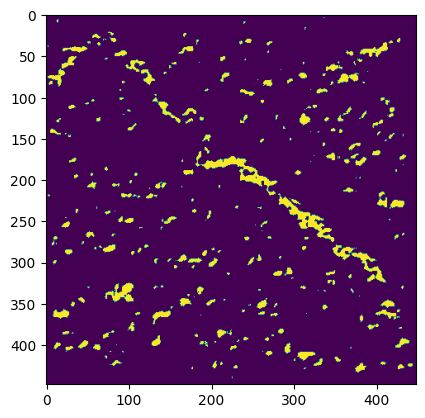

In [75]:
eval(predicted_masks[0].detach().numpy(), origin_masks[0].detach().numpy())

In [70]:
compare( predicted_masks[0].detach().numpy(), origin_masks[0].detach().numpy())

precision, recall, dice:  0 0 0


(0, 0, 0)